In [46]:
import os
import numpy as np
import torch
from torchsummary import summary
import copy

import scipy.io.wavfile
import cupy as cp
import cusignal

from IPython.display import Audio

In [2]:
class data_from_dir(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, file_dir, resample=False):
        'Initialization'
        self.resample = resample
        self.file_dir = file_dir
        self.file_filenames = [ x for x in os.listdir(file_dir) ]
        
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.file_filenames)

    def __getitem__(self, index, resample=False):
        'Load one sample of data'
        # Select sample
        sr, wave = scipy.io.wavfile.read(os.path.join(self.file_dir, self.file_filenames[index]))
        if self.resample:
            # Let's resample and scale:
            target_length = 5 # seconds
            target_sr = 48000 # sampling rate, samples per second
            wave_gpu = cp.asarray(wave)
            resampled_wave_gpu = cusignal.resample(wave_gpu, target_sr*target_length)
            resampled_wave = cp.asnumpy(resampled_wave_gpu).astype(int)
            scaled_wave = np.int16(resampled_wave/np.max(np.abs(resampled_wave)) * 32767)
            return scaled_wave.reshape(1, -1) # each element in array is one-dimensional, so need to reshape as 1-dimensional array
        else:
            return wave.reshape(1, -1)
            

In [3]:
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = torch.nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = torch.nn.functional.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [4]:
%%time
# dataset = data_from_dir("../data/dataset/resampled", resample=False) # load already prepared and resampled files
# dataset = data_from_dir("../data/dataset/25G_train", resample=False) # load already prepared and resampled files
dataset = data_from_dir("../data/dataset/small", resample=False) # load already prepared and resampled files
print("Dataset size: ", len(dataset))

# # check all files to be consistent before pass to neural network
# for index, wave in enumerate(dataset):
#     if len(wave[0]) != 240000:
#         print("Size error:     ", dataset.file_filenames[index])
#         print("Current length: ", len(dataset[index]))
#         break
# if index+1 == len(dataset):
#     print("All files consistent and have same length 240k amplitudes each")
# print()
# print()

# wave

Dataset size:  2000
CPU times: user 1.53 ms, sys: 219 µs, total: 1.75 ms
Wall time: 1.25 ms


In [5]:
%%time
# check one file in dataset to be sure everything is good:
file_number=7
wave = dataset[file_number][0]
sr = 48000

print('Type:              ', type(wave))
print('Data:              ', wave)
print('Sampling rate:     ', sr)
print('Samples:           ', len(wave))
print('Audio length:      ', round(wave.size/sr, 4), 'seconds')
print('Lowest amplitude:  ', min(wave))
print('Highest amplitude: ', max(wave))
print()
print("Scaled from dataset:")
Audio(wave, rate=sr)


Type:               <class 'numpy.ndarray'>
Data:               [ -8647 -10090  -9741 ...  -2161  -2124  -3448]
Sampling rate:      48000
Samples:            240000
Audio length:       5.0 seconds
Lowest amplitude:   -27862
Highest amplitude:  32767

Scaled from dataset:
CPU times: user 128 ms, sys: 3.99 ms, total: 132 ms
Wall time: 137 ms


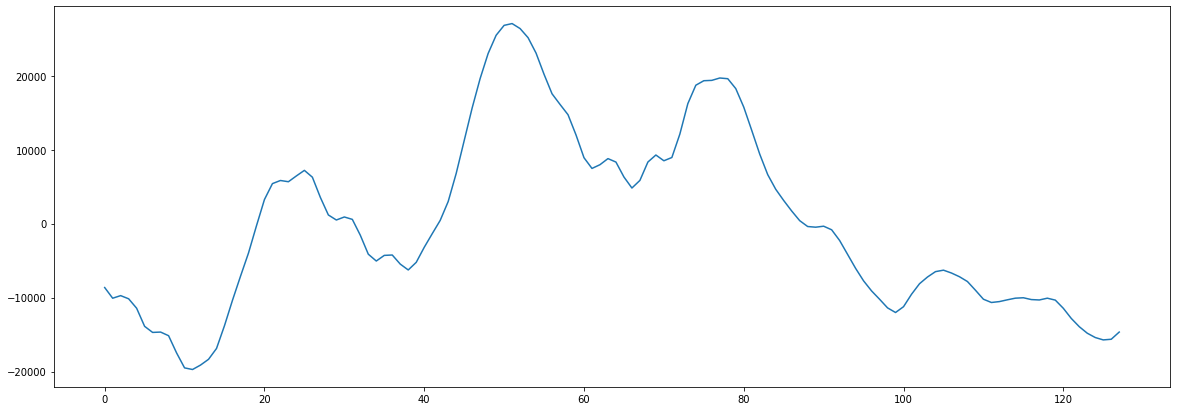

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,7))
plt.plot(dataset[file_number][0][0:128]) # plotting by columns
plt.show()

In [7]:
%%time
print("Original source:")
sr, wave = scipy.io.wavfile.read(os.path.join("../data/sliced", dataset.file_filenames[file_number]))
Audio(wave, rate=sr)

Original source:
CPU times: user 0 ns, sys: 4.25 ms, total: 4.25 ms
Wall time: 3.37 ms


In [8]:
%%time
# now split whole dataset to train and test subsets
# get 50% for tests

train_size = int(0.5 * len(dataset))
# train_size = int(0.961 * len(dataset))
# train_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
print("Train dataset size: ", len(train_dataset))
print("Test dataset size:  ", len(test_dataset))
print()

Train dataset size:  1000
Test dataset size:   1000

CPU times: user 913 µs, sys: 120 µs, total: 1.03 ms
Wall time: 577 µs


In [9]:
%%time
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True) #, num_workers=4) # num_workers have an issue, not working
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True) #, num_workers=4)

CPU times: user 112 µs, sys: 14 µs, total: 126 µs
Wall time: 133 µs


In [10]:
### library for plot online update
from livelossplot import PlotLosses

dataloaders = {
    "train": train_loader,
    "test": test_loader
}

In [11]:
# for idx, inputs in enumerate(train_loader):
#     None
# amplitude_range = 32767*2+1.0 # = 65535
# normalized = 0.5 + inputs/amplitude_range # [0..1]

In [12]:
# # describe model architecture

# class ConvAutoencoder(torch.nn.Module):
#     def __init__(self):
#         super(ConvAutoencoder, self).__init__()
#         kernel_size_1 = int(64) # 128, stride=2, pool=2
#         kernel_size_2 = int(32) # 25
#         kernel_size_3 = int(25) # 9
#         kernel_size_4 = int(25) # 5
#         kernel_size_5 = int(25) # 5
#         kernel_size_6 = int(25) # 5
#         kernel_size_7 = int(3) # 5
#         kernel_size_8 = int(3) # 5

#         padding_1 = int((kernel_size_1 - 1)/2) # 
#         padding_2 = int((kernel_size_2 - 1)/2) # 
#         padding_3 = int((kernel_size_3 - 1)/2) # 
#         padding_4 = int((kernel_size_4 - 1)/2) # 
#         padding_5 = int((kernel_size_5 - 1)/2) # 
#         padding_6 = int((kernel_size_6 - 1)/2) # 
#         padding_7 = 0 # int((kernel_size_7 - 1)/2) # 
#         padding_8 = int((kernel_size_8 - 1)/2) # 

#         # 240k - 9600 - 600 - 40 - 5 - 1
#         # encoder
#         # 240k -> 15000
#         #
#         # ReLU = 0.0056
#         # ReLU6 = 0.0055
#         # LeakyReLU(0.1) = 0.0053
#         # Hardtanh = 0.0072
#         # PReLU = 0.0055
#         # RReLU = 0.0055
#         # SELU = 0.0067
        
#         self.enc1co = torch.nn.Conv1d(1, 32, kernel_size=kernel_size_1, stride=16, padding=padding_1, bias=False)
#         self.enc1bn = torch.nn.BatchNorm1d(32)
#         self.enc1ac = torch.nn.ReLU6()
# #         self.enc1mp = torch.nn.MaxPool1d(kernel_size=4, stride=4, return_indices=True)

#         # 15000 -> 1850
#         self.enc2co = torch.nn.Conv1d(32, 64, kernel_size=kernel_size_2, stride=8, padding=padding_2, bias=False)
#         self.enc2bn = torch.nn.BatchNorm1d(64)
#         self.enc2ac = torch.nn.ReLU6()
# #         self.enc2mp = torch.nn.MaxPool1d(kernel_size=5, stride=5, return_indices=True)

#         # 1850 -> 375
#         self.enc3co = torch.nn.Conv1d(64, 128, kernel_size=kernel_size_3, stride=5, padding=padding_3, bias=False)
#         self.enc3bn = torch.nn.BatchNorm1d(128)
#         self.enc3ac = torch.nn.ReLU6()
# #         self.enc3mp = torch.nn.MaxPool1d(kernel_size=5, stride=5, return_indices=True)

#         # 375 -> 75
#         self.enc4co = torch.nn.Conv1d(128, 256, kernel_size=kernel_size_4, stride=5, padding=padding_4, bias=False)
#         self.enc4bn = torch.nn.BatchNorm1d(256)
#         self.enc4ac = torch.nn.ReLU6()
# #         self.enc4mp = torch.nn.MaxPool1d(kernel_size=5, stride=5, return_indices=True)

#         # 75 -> 15
#         self.enc5co = torch.nn.Conv1d(256, 512, kernel_size=kernel_size_5, stride=5, padding=padding_5, bias=False)
#         self.enc5bn = torch.nn.BatchNorm1d(512)
#         self.enc5ac = torch.nn.ReLU6()
# #         self.enc5mp = torch.nn.MaxPool1d(kernel_size=5, stride=5, return_indices=True)

#         # 15 -> 3
#         self.enc6co = torch.nn.Conv1d(512, 1024, kernel_size=kernel_size_6, stride=5, padding=padding_6, bias=False)
#         self.enc6bn = torch.nn.BatchNorm1d(1024)
#         self.enc6ac = torch.nn.ReLU6()
# #         self.enc6mp = torch.nn.MaxPool1d(kernel_size=5, stride=5, return_indices=True)

#         # 3 -> 1
#         self.enc7co = torch.nn.Conv1d(1024, 2048, kernel_size=kernel_size_7, stride=3, padding=padding_7, bias=False)
#         self.enc7bn = torch.nn.BatchNorm1d(2048)
#         self.enc7ac = torch.nn.ReLU6()
# #         self.enc7mp = torch.nn.MaxPool1d(kernel_size=3, stride=3, return_indices=True)

# #         # 2 -> 1
# #         self.enc8co = torch.nn.Conv1d(512, 512, kernel_size=kernel_size_8, stride=1, padding=padding_8)
# #         self.enc8bn = torch.nn.BatchNorm1d(512)
# #         self.enc8ac = torch.nn.ReLU()
# #         self.enc8mp = torch.nn.MaxPool1d(kernel_size=2, stride=2, return_indices=True)

# #         # decoder 
# #         self.dec8mup = torch.nn.MaxUnpool1d(kernel_size=2, stride=2)
# #         self.dec8uco = torch.nn.ConvTranspose1d(512, 512, kernel_size=kernel_size_8, stride=1, padding=padding_8)
# #         self.dec8bn = torch.nn.BatchNorm1d(512)
# #         self.dec8ac = torch.nn.ReLU()
        
# #         self.dec7mup = torch.nn.MaxUnpool1d(kernel_size=3, stride=3)
#         self.dec7uco = torch.nn.ConvTranspose1d(2048, 1024, kernel_size=kernel_size_7, stride=3, padding=padding_7, bias=False)
#         self.dec7bn = torch.nn.BatchNorm1d(1024)
#         self.dec7ac = torch.nn.ReLU6()
        
# #         self.dec6mup = torch.nn.MaxUnpool1d(kernel_size=5, stride=5)
#         self.dec6uco = torch.nn.ConvTranspose1d(1024, 512, kernel_size=kernel_size_6, stride=5, padding=padding_6-2, bias=False)
#         self.dec6bn = torch.nn.BatchNorm1d(512)
#         self.dec6ac = torch.nn.ReLU6()

# #         self.dec5mup = torch.nn.MaxUnpool1d(kernel_size=5, stride=5)
#         self.dec5uco = torch.nn.ConvTranspose1d(512, 256, kernel_size=kernel_size_5, stride=5, padding=padding_5-2, bias=False)
#         self.dec5bn = torch.nn.BatchNorm1d(256)
#         self.dec5ac = torch.nn.ReLU6()
        
# #         self.dec4mup = torch.nn.MaxUnpool1d(kernel_size=5, stride=5)
#         self.dec4uco = torch.nn.ConvTranspose1d(256, 128, kernel_size=kernel_size_4, stride=5, padding=padding_4-2, bias=False)
#         self.dec4bn = torch.nn.BatchNorm1d(128)
#         self.dec4ac = torch.nn.ReLU6()

# #         self.dec3mup = torch.nn.MaxUnpool1d(kernel_size=5, stride=5)
#         self.dec3uco = torch.nn.ConvTranspose1d(128, 64, kernel_size=kernel_size_3, stride=5, padding=padding_3-2, bias=False)
#         self.dec3bn = torch.nn.BatchNorm1d(64)
#         self.dec3ac = torch.nn.ReLU6()

# #         self.dec2mup = torch.nn.MaxUnpool1d(kernel_size=5, stride=5)
#         self.dec2uco = torch.nn.ConvTranspose1d(64, 32, kernel_size=kernel_size_2, stride=8, padding=padding_2-3, bias=False)
#         self.dec2bn = torch.nn.BatchNorm1d(32)
#         self.dec2ac = torch.nn.ReLU6()
        
# #         self.dec1mup = torch.nn.MaxUnpool1d(kernel_size=4, stride=4)
#         self.dec1uco = torch.nn.ConvTranspose1d(32, 1, kernel_size=kernel_size_1, stride=16, padding=padding_1-7, bias=False)
#         self.dec1bn = torch.nn.BatchNorm1d(1)
#         self.dec1ac = torch.nn.Sigmoid() # data range will be transformed to [0..1]
        
#         # now initialize weights
#         torch.nn.init.kaiming_uniform_(self.enc1co.weight)
#         torch.nn.init.kaiming_uniform_(self.enc2co.weight)
#         torch.nn.init.kaiming_uniform_(self.enc3co.weight)
#         torch.nn.init.kaiming_uniform_(self.enc4co.weight)
#         torch.nn.init.kaiming_uniform_(self.enc5co.weight)
#         torch.nn.init.kaiming_uniform_(self.enc6co.weight)
#         torch.nn.init.kaiming_uniform_(self.enc7co.weight)
# #         torch.nn.init.kaiming_uniform_(self.enc8co.weight)
#         torch.nn.init.kaiming_uniform_(self.dec1uco.weight)
#         torch.nn.init.kaiming_uniform_(self.dec2uco.weight)
#         torch.nn.init.kaiming_uniform_(self.dec3uco.weight)
#         torch.nn.init.kaiming_uniform_(self.dec4uco.weight)
#         torch.nn.init.kaiming_uniform_(self.dec5uco.weight)
#         torch.nn.init.kaiming_uniform_(self.dec6uco.weight)
#         torch.nn.init.kaiming_uniform_(self.dec7uco.weight)
# #         torch.nn.init.kaiming_uniform_(self.dec8uco.weight)

# #         self.conv6 = DoubleConv(1024, 512)
# #         self.conv5 = DoubleConv(512, 256)
# #         self.conv4 = DoubleConv(512, 256)
# #         self.conv3 = DoubleConv(256, 128)
# #         self.conv2 = DoubleConv(128, 64)
# #         self.conv1 = DoubleConv(64, 32)


#     def forward(self, x):
# #         print(x.shape)
#         enc1 = self.enc1co(x)
#         enc1 = self.enc1bn(enc1)
#         enc1 = self.enc1ac(enc1)
# #         x,self.idx1 = self.enc1mp(x)
# #         print(x.shape)
#         enc2 = self.enc2co(enc1)
#         enc2 = self.enc2bn(enc2)
#         enc2 = self.enc2ac(enc2)
# #         x,self.idx2 = self.enc2mp(x)
#         enc3 = self.enc3co(enc2)
#         enc3 = self.enc3bn(enc3)
#         enc3 = self.enc3ac(enc3)
# #         x,self.idx3 = self.enc3mp(x)
#         enc4 = self.enc4co(enc3)
#         enc4 = self.enc4bn(enc4)
#         enc4 = self.enc4ac(enc4)
# #         x,self.idx4 = self.enc4mp(x)
#         enc5 = self.enc5co(enc4)
#         enc5 = self.enc5bn(enc5)
#         enc5 = self.enc5ac(enc5)
# #         x,self.idx5 = self.enc5mp(x)
#         enc6 = self.enc6co(enc5)
#         enc6 = self.enc6bn(enc6)
#         enc6 = self.enc6ac(enc6)
# #         x,self.idx6 = self.enc6mp(x)
#         enc7 = self.enc7co(enc6)
#         enc7 = self.enc7bn(enc7)
#         enc7 = self.enc7ac(enc7)
# #         x,self.idx7 = self.enc7mp(x)
# #         x = self.enc8co(x)
# #         x = self.enc8bn(x)
# #         x = self.enc8ac(x)
# #         x,self.idx8 = self.enc8mp(x)

# #         x = self.dec8mup(x, self.idx8)
# #         x = self.dec8uco(x)
# #         x = self.dec8bn(x)
# #         x = self.dec8ac(x)
# #         x = self.dec7mup(x, self.idx7)
#         x = self.dec7uco(enc7)
#         x = self.dec7bn(x)
#         x = self.dec7ac(x)
# #         x = self.dec6mup(x, self.idx6)
# #         if self.training:
# #             x = self.conv6(torch.cat([x, enc6], dim=1)) # 512*2
#         x = self.dec6uco(x)
#         x = self.dec6bn(x)
#         x = self.dec6ac(x)
# #         x = self.dec5mup(x, self.idx5)
# #         if self.training:
# #             x = self.conv5(torch.cat([x, enc5], dim=1))
#         x = self.dec5uco(x)
#         x = self.dec5bn(x)
#         x = self.dec5ac(x)
# #         x = self.dec4mup(x, self.idx4)
# #         if self.training:
# #             x = self.conv4(torch.cat([x, enc4], dim=1))
#         x = self.dec4uco(x)
#         x = self.dec4bn(x)
#         x = self.dec4ac(x)
# #         x = self.dec3mup(x, self.idx3)
# #         if self.training:
# #             x = self.conv3(torch.cat([x, enc3], dim=1))
#         x = self.dec3uco(x)
#         x = self.dec3bn(x)
#         x = self.dec3ac(x)
# #         print(x.shape)
# #         x = self.dec2mup(x, self.idx2)
# #         if self.training:
# #             x = self.conv2(torch.cat([x, enc2], dim=1))
#         x = self.dec2uco(x)
#         x = self.dec2bn(x)
#         x = self.dec2ac(x)
# #         print(x.shape)
# #         x = self.dec1mup(x, self.idx1)
# #         if self.training:
# #             x = self.conv1(torch.cat([x, enc1], dim=1))
#         x = self.dec1uco(x)
#         x = self.dec1bn(x)
#         x = self.dec1ac(x)
# #         print(x.shape)

#         return x

In [13]:
# describe model architecture

class ConvAutoencoder(torch.nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        kernel_size_1 = int(64) # 128, stride=2, pool=2
        kernel_size_2 = int(25) # 25
        kernel_size_3 = int(25) # 9
        kernel_size_4 = int(16) # 5
        kernel_size_5 = int(9) # 5
        kernel_size_6 = int(25) # 5
        kernel_size_7 = int(3) # 5
        kernel_size_8 = int(3) # 5

        padding_1 = int((kernel_size_1 - 1)/2) # 
        padding_2 = int((kernel_size_2 - 1)/2) # 
        padding_3 = int((kernel_size_3 - 1)/2) # 
        padding_4 = int((kernel_size_4 - 1)/2) # 
        padding_5 = int((kernel_size_5 - 1)/2) # 
        padding_6 = int((kernel_size_6 - 1)/2) # 
        padding_7 = 0 # int((kernel_size_7 - 1)/2) # 
        padding_8 = int((kernel_size_8 - 1)/2) # 

        # 240k - 9600 - 600 - 40 - 5 - 1
        # encoder
        # 240k -> 15000
        #
        # ReLU = 0.0056
        # ReLU6 = 0.0055
        # LeakyReLU(0.1) = 0.0053
        # Hardtanh = 0.0072
        # PReLU = 0.0055
        # RReLU = 0.0055
        # SELU = 0.0067
        self.activation = torch.nn.LeakyReLU(0.1)

        self.enc1co = torch.nn.Conv1d(1, 32, kernel_size=kernel_size_1, stride=16, padding=padding_1, bias=False)
        self.enc1bn = torch.nn.BatchNorm1d(32)
        self.enc1ac = self.activation
#         self.enc1mp = torch.nn.MaxPool1d(kernel_size=4, stride=4, return_indices=True)

        # 15000 -> 1850
        self.enc2co = torch.nn.Conv1d(32, 64, kernel_size=kernel_size_2, stride=5, padding=padding_2, bias=False)
        self.enc2bn = torch.nn.BatchNorm1d(64)
        self.enc2ac = self.activation
        self.enc2mp = torch.nn.MaxPool1d(kernel_size=5, stride=5, return_indices=True)

        # 1850 -> 375
        self.enc3co = torch.nn.Conv1d(64, 128, kernel_size=kernel_size_3, stride=5, padding=padding_3, bias=False)
        self.enc3bn = torch.nn.BatchNorm1d(128)
        self.enc3ac = self.activation
        self.enc3mp = torch.nn.MaxPool1d(kernel_size=5, stride=5, return_indices=True)

        # 375 -> 75
        self.enc4co = torch.nn.Conv1d(128, 256, kernel_size=kernel_size_4, stride=4, padding=padding_4, bias=False)
        self.enc4bn = torch.nn.BatchNorm1d(256)
        self.enc4ac = self.activation
        self.enc4mp = torch.nn.MaxPool1d(kernel_size=2, stride=2, return_indices=True)

        # 75 -> 15
        self.enc5co = torch.nn.Conv1d(256, 512, kernel_size=kernel_size_5, stride=3, padding=padding_5, bias=False)
        self.enc5bn = torch.nn.BatchNorm1d(512)
        self.enc5ac = self.activation
#         self.enc5mp = torch.nn.MaxPool1d(kernel_size=2, stride=2, return_indices=True)

        # 15 -> 3
#         self.enc6co = torch.nn.Conv1d(512, 1024, kernel_size=kernel_size_6, stride=5, padding=padding_6, bias=False)
#         self.enc6bn = torch.nn.BatchNorm1d(1024)
#         self.enc6ac = torch.nn.ReLU6()
# #         self.enc6mp = torch.nn.MaxPool1d(kernel_size=5, stride=5, return_indices=True)

#         # 3 -> 1
#         self.enc7co = torch.nn.Conv1d(1024, 2048, kernel_size=kernel_size_7, stride=3, padding=padding_7, bias=False)
#         self.enc7bn = torch.nn.BatchNorm1d(2048)
#         self.enc7ac = torch.nn.ReLU6()
#         self.enc7mp = torch.nn.MaxPool1d(kernel_size=3, stride=3, return_indices=True)

#         # 2 -> 1
#         self.enc8co = torch.nn.Conv1d(512, 512, kernel_size=kernel_size_8, stride=1, padding=padding_8)
#         self.enc8bn = torch.nn.BatchNorm1d(512)
#         self.enc8ac = torch.nn.ReLU()
#         self.enc8mp = torch.nn.MaxPool1d(kernel_size=2, stride=2, return_indices=True)

#         # decoder 
#         self.dec8mup = torch.nn.MaxUnpool1d(kernel_size=2, stride=2)
#         self.dec8uco = torch.nn.ConvTranspose1d(512, 512, kernel_size=kernel_size_8, stride=1, padding=padding_8)
#         self.dec8bn = torch.nn.BatchNorm1d(512)
#         self.dec8ac = torch.nn.ReLU()
        
#         self.dec7mup = torch.nn.MaxUnpool1d(kernel_size=3, stride=3)
#         self.dec7uco = torch.nn.ConvTranspose1d(2048, 1024, kernel_size=kernel_size_7, stride=3, padding=padding_7, bias=False)
#         self.dec7bn = torch.nn.BatchNorm1d(1024)
#         self.dec7ac = torch.nn.ReLU6()
        
# #         self.dec6mup = torch.nn.MaxUnpool1d(kernel_size=5, stride=5)
#         self.dec6uco = torch.nn.ConvTranspose1d(1024, 512, kernel_size=kernel_size_6, stride=5, padding=padding_6-2, bias=False)
#         self.dec6bn = torch.nn.BatchNorm1d(512)
#         self.dec6ac = torch.nn.ReLU6()

#         self.dec5mup = torch.nn.MaxUnpool1d(kernel_size=2, stride=2)
        self.dec5uco = torch.nn.ConvTranspose1d(512, 256, kernel_size=kernel_size_5, stride=3, padding=padding_5-1, bias=False)
        self.dec5bn = torch.nn.BatchNorm1d(256)
        self.dec5ac = self.activation
        
        self.dec4mup = torch.nn.MaxUnpool1d(kernel_size=2, stride=2)
        self.dec4uco = torch.nn.ConvTranspose1d(256, 128, kernel_size=kernel_size_4, stride=4, padding=padding_4-1, bias=False)
        self.dec4bn = torch.nn.BatchNorm1d(128)
        self.dec4ac = self.activation

        self.dec3mup = torch.nn.MaxUnpool1d(kernel_size=5, stride=5)
        self.dec3uco = torch.nn.ConvTranspose1d(128, 64, kernel_size=kernel_size_3, stride=5, padding=padding_3-2, bias=False)
        self.dec3bn = torch.nn.BatchNorm1d(64)
        self.dec3ac = self.activation

        self.dec2mup = torch.nn.MaxUnpool1d(kernel_size=5, stride=5)
        self.dec2uco = torch.nn.ConvTranspose1d(64, 32, kernel_size=kernel_size_2, stride=5, padding=padding_2-2, bias=False)
        self.dec2bn = torch.nn.BatchNorm1d(32)
        self.dec2ac = self.activation
        
#         self.dec1mup = torch.nn.MaxUnpool1d(kernel_size=4, stride=4)
        self.dec1uco = torch.nn.ConvTranspose1d(32, 1, kernel_size=kernel_size_1, stride=16, padding=padding_1-7, bias=False)
        self.dec1bn = torch.nn.BatchNorm1d(1)
        self.dec1ac = torch.nn.Sigmoid() # data range will be transformed to [0..1]
        
        # now initialize weights
        torch.nn.init.kaiming_uniform_(self.enc1co.weight)
        torch.nn.init.kaiming_uniform_(self.enc2co.weight)
        torch.nn.init.kaiming_uniform_(self.enc3co.weight)
        torch.nn.init.kaiming_uniform_(self.enc4co.weight)
        torch.nn.init.kaiming_uniform_(self.enc5co.weight)
#         torch.nn.init.kaiming_uniform_(self.enc6co.weight)
#         torch.nn.init.kaiming_uniform_(self.enc7co.weight)
#         torch.nn.init.kaiming_uniform_(self.enc8co.weight)
        torch.nn.init.kaiming_uniform_(self.dec1uco.weight)
        torch.nn.init.kaiming_uniform_(self.dec2uco.weight)
        torch.nn.init.kaiming_uniform_(self.dec3uco.weight)
        torch.nn.init.kaiming_uniform_(self.dec4uco.weight)
        torch.nn.init.kaiming_uniform_(self.dec5uco.weight)
#         torch.nn.init.kaiming_uniform_(self.dec6uco.weight)
#         torch.nn.init.kaiming_uniform_(self.dec7uco.weight)
#         torch.nn.init.kaiming_uniform_(self.dec8uco.weight)

#         self.conv6 = DoubleConv(1024, 512)
#         self.conv5 = DoubleConv(512, 256)
#         self.conv4 = DoubleConv(512, 256)
#         self.conv3 = DoubleConv(256, 128)
#         self.conv2 = DoubleConv(128, 64)
#         self.conv1 = DoubleConv(64, 32)


    def l5(self, x):
#         print(x.shape)
        x = self.enc1co(x)
        x = self.enc1bn(x)
        x = self.enc1ac(x)
#         print(x.shape)
#         x,self.idx1 = self.enc1mp(x)
        x = self.enc2co(x)
        x = self.enc2bn(x)
        x = self.enc2ac(x)
        x,self.idx2 = self.enc2mp(x)
#         print(x.shape)
        x = self.enc3co(x)
        x = self.enc3bn(x)
        x = self.enc3ac(x)
        x,self.idx3 = self.enc3mp(x)
#         print(x.shape)
        x = self.enc4co(x)
        x = self.enc4bn(x)
        x = self.enc4ac(x)
        x,self.idx4 = self.enc4mp(x)
#         print(x.shape, self.idx4.shape)
        x = self.enc5co(x)
        x = self.enc5bn(x)
        x = self.enc5ac(x)
        # x = self.enc5ac(self.enc5bn(self.enc5co(x)))
#         x,self.idx5 = self.enc5mp(x)
#         print(x.shape)
#         enc6 = self.enc6co(enc5)
#         enc6 = self.enc6bn(enc6)
#         enc6 = self.enc6ac(enc6)
# #         x,self.idx6 = self.enc6mp(x)
#         enc7 = self.enc7co(enc6)
#         enc7 = self.enc7bn(enc7)
#         enc7 = self.enc7ac(enc7)
#         x,self.idx7 = self.enc7mp(x)
#         x = self.enc8co(x)
#         x = self.enc8bn(x)
#         x = self.enc8ac(x)
#         x,self.idx8 = self.enc8mp(x)

#         x = self.dec8mup(x, self.idx8)
#         x = self.dec8uco(x)
#         x = self.dec8bn(x)
#         x = self.dec8ac(x)
#         x = self.dec7mup(x, self.idx7)
#         x = self.dec7uco(enc7)
#         x = self.dec7bn(x)
#         x = self.dec7ac(x)
# #         x = self.dec6mup(x, self.idx6)
# #         if self.training:
# #             x = self.conv6(torch.cat([x, enc6], dim=1)) # 512*2
#         x = self.dec6uco(x)
#         x = self.dec6bn(x)
#         x = self.dec6ac(x)
#         x = self.dec5mup(x, self.idx5)
        # x = self.dec5ac(self.dec5bn(self.dec5uco(x)))
        x = self.dec5uco(x)
        x = self.dec5bn(x)
        x = self.dec5ac(x)
#         print(x.shape, self.idx4.shape)
        x = self.dec4mup(x, self.idx4)
        x = self.dec4uco(x)
        x = self.dec4bn(x)
        x = self.dec4ac(x)
#         print(x.shape)
        x = self.dec3mup(x, self.idx3)
        x = self.dec3uco(x)
        x = self.dec3bn(x)
        x = self.dec3ac(x)
#         print(x.shape)
        x = self.dec2mup(x, self.idx2)
        x = self.dec2uco(x)
        x = self.dec2bn(x)
        x = self.dec2ac(x)
#         print(x.shape)
#         x = self.dec1mup(x, self.idx1)
        x = self.dec1uco(x)
        x = self.dec1bn(x)
        x = self.dec1ac(x)
        return x
    
    def l1(self, x):
        x = self.enc1ac(self.enc1bn(self.enc1co(x)))
        x = self.dec1ac(self.dec1bn(self.dec1uco(x)))
        return x
    def l2(self, x):
        x = self.enc1ac(self.enc1bn(self.enc1co(x)))
        x = self.enc2ac(self.enc2bn(self.enc2co(x)))
        x,self.idx2 = self.enc2mp(x)
        x = self.dec2mup(x, self.idx2)
        x = self.dec2ac(self.dec2bn(self.dec2uco(x)))
        x = self.dec1ac(self.dec1bn(self.dec1uco(x)))
        return x
    def l3(self, x):
        x = self.enc1ac(self.enc1bn(self.enc1co(x)))
        x = self.enc2ac(self.enc2bn(self.enc2co(x)))
        x,self.idx2 = self.enc2mp(x)
        x = self.enc3ac(self.enc3bn(self.enc3co(x)))
        x,self.idx3 = self.enc3mp(x)
        x = self.dec3mup(x, self.idx3)
        x = self.dec3ac(self.dec3bn(self.dec3uco(x)))
        x = self.dec2mup(x, self.idx2)
        x = self.dec2ac(self.dec2bn(self.dec2uco(x)))
        x = self.dec1ac(self.dec1bn(self.dec1uco(x)))
        return x
    def l4(self, x):
        x = self.enc1ac(self.enc1bn(self.enc1co(x)))
        x = self.enc2ac(self.enc2bn(self.enc2co(x)))
        x,self.idx2 = self.enc2mp(x)
        x = self.enc3ac(self.enc3bn(self.enc3co(x)))
        x,self.idx3 = self.enc3mp(x)
        x = self.enc4ac(self.enc4bn(self.enc4co(x)))
        x,self.idx4 = self.enc4mp(x)
        x = self.dec4mup(x, self.idx4)
        x = self.dec4ac(self.dec4bn(self.dec4uco(x)))
        x = self.dec3mup(x, self.idx3)
        x = self.dec3ac(self.dec3bn(self.dec3uco(x)))
        x = self.dec2mup(x, self.idx2)
        x = self.dec2ac(self.dec2bn(self.dec2uco(x)))
        x = self.dec1ac(self.dec1bn(self.dec1uco(x)))
        return x

In [14]:
model = ConvAutoencoder()
model.cuda() # need to be set to cuda to get summary working
summary(model, (1, 240000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 32, 15000]           2,048
       BatchNorm1d-2            [-1, 32, 15000]              64
         LeakyReLU-3            [-1, 32, 15000]               0
            Conv1d-4             [-1, 64, 3000]          51,200
       BatchNorm1d-5             [-1, 64, 3000]             128
         LeakyReLU-6             [-1, 64, 3000]               0
         MaxPool1d-7  [[-1, 64, 600], [-1, 64, 600]]               0
            Conv1d-8             [-1, 128, 120]         204,800
       BatchNorm1d-9             [-1, 128, 120]             256
        LeakyReLU-10             [-1, 128, 120]               0
        MaxPool1d-11  [[-1, 128, 24], [-1, 128, 24]]               0
           Conv1d-12               [-1, 256, 6]         524,288
      BatchNorm1d-13               [-1, 256, 6]             512
        LeakyReLU-14         

In [15]:
# train on cuda if available
torch.cuda.empty_cache()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# train with (test on each epoch)
def train_model(model, criterion, optimizer, num_epochs=10):
    liveloss = PlotLosses()
    model = model.to(device)
    amplitude_range = 32767*2 + 1.0 # = 65535
#     softmaxed = torch.nn.Softmax()
    
    for epoch_id, epoch in enumerate(range(num_epochs)):
        logs = {}
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            # running_corrects = 0 # no correct answers for autoencoders

            for idx, inputs in enumerate(dataloaders[phase]):
                inputs = 0.5 + (inputs/amplitude_range) # [0..1]
                inputs = inputs.to(device)
                outputs = model.l5(inputs)
                loss = (criterion(outputs, inputs))

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                # _, preds = torch.max(outputs, 1) # no correct answers for autoencoders
                running_loss += loss.detach() * inputs.size(0)
                # running_corrects += torch.sum(preds == inputs.data) # no correct answers for autoencoders
                # running_corrects += torch.sum(preds == labels.data) # no correct answers for autoencoders
                ###print(f"\r[{idx}/{len(source_files)}] {round(100.0 * idx/len(source_files), 2)}%: {j}", end = "")
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            # epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
            
            prefix = ''
            if phase == 'test':
                prefix = 'val_'
            logs[prefix + 'log loss'] = epoch_loss.item()
        liveloss.update(logs)
        liveloss.send()
        print(f"\n[{epoch_id+1}/{num_epochs}]    {logs}")
    print("\nTrained.")

In [16]:
torch.cuda.empty_cache()
model = ConvAutoencoder()
criterion = torch.nn.MSELoss()
# criterion = FocalLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005) # [0.001 .. 0.0005 ... 0.0001] 0.001 per 10 epochs & 0.00001 per 1000 epochs

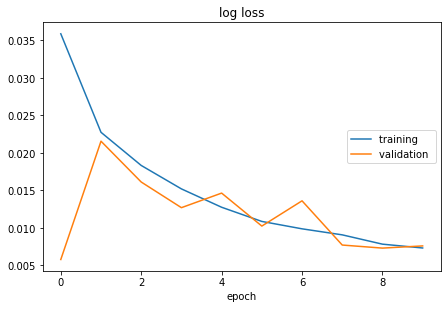

log loss
	training         	 (min:    0.007, max:    0.036, cur:    0.007)
	validation       	 (min:    0.006, max:    0.022, cur:    0.008)

[10/10]    {'log loss': 0.007319670170545578, 'val_log loss': 0.0075952461920678616}

Trained.
CPU times: user 1min 32s, sys: 16.6 s, total: 1min 48s
Wall time: 27.5 s


In [17]:
%%time
train_model(model, criterion, optimizer, num_epochs=10) # start @ 10:35:30

In [18]:
%%time
validation_dataset = data_from_dir("../data/dataset/test", resample=False) # load already prepared and resampled files
print("Dataset size: ", len(validation_dataset))

# check one file in dataset to be sure everything is good:
file_number=25
wave = validation_dataset[file_number][0]
sr = 48000

print('Type:              ', type(wave))
print('Data:              ', wave)
print('Sampling rate:     ', sr)
print('Samples:           ', len(wave))
print('Audio length:      ', round(wave.size/sr, 4), 'seconds')
print('Lowest amplitude:  ', min(wave))
print('Highest amplitude: ', max(wave))
print()
print("Scaled from dataset:")
Audio(wave, rate=sr)

Dataset size:  524
Type:               <class 'numpy.ndarray'>
Data:               [ -366   -15   -30 ... -2446 -1957 -1131]
Sampling rate:      48000
Samples:            240000
Audio length:       5.0 seconds
Lowest amplitude:   -27736
Highest amplitude:  32767

Scaled from dataset:
CPU times: user 113 ms, sys: 3.98 ms, total: 117 ms
Wall time: 112 ms


In [19]:
wave = validation_dataset[file_number][0]
amplitude_range = 32767*2+1.0 # = 65535
inputs = torch.Tensor([[0.5 + wave/amplitude_range]]) # [0..1]
inputs = inputs.to(device)
outputs = model.l5(inputs)
loss = (criterion(outputs, inputs))
print(f"loss: {loss.item()}")
result = np.int16(((outputs - 0.5)*(amplitude_range-1)).detach().cpu())
Audio(result[0][0], rate=sr)

loss: 0.023331353440880775


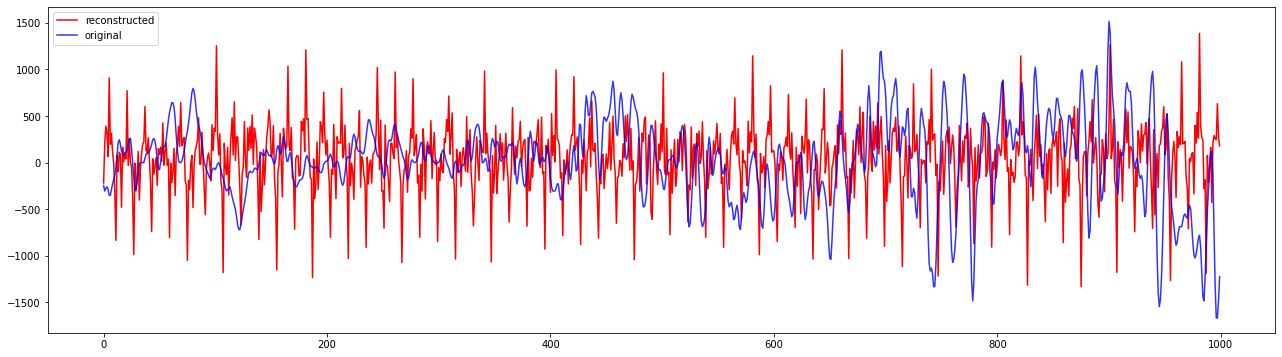

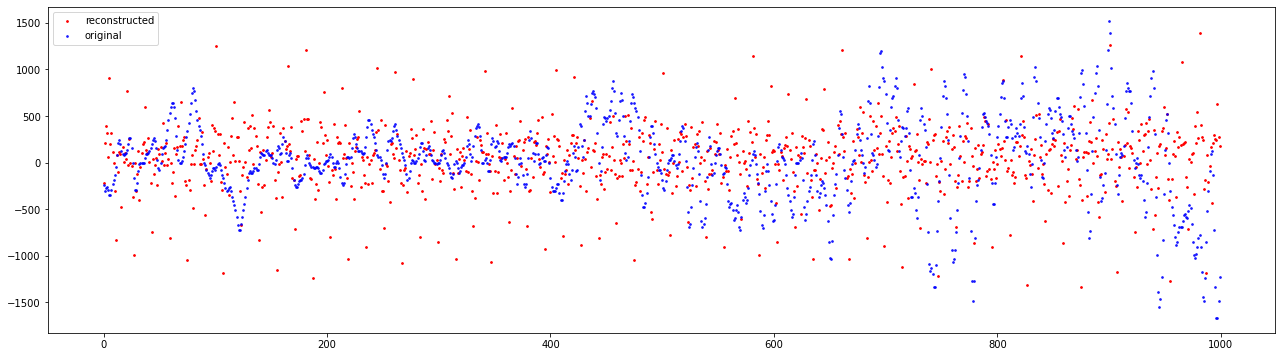

In [20]:
amp_start = 1000
amp_end =   2000
plt.figure(figsize=(22,6))
plt.plot(result[0][0][amp_start:amp_end], linestyle="-", color=[1.0, 0.0, 0.0, 1.0], label="reconstructed") # plotting by columns
plt.plot(wave[amp_start:amp_end], linestyle="-", color=[0.0, 0.0, 1.0, 0.8], label="original") # plotting by columns
plt.legend(loc="upper left")
plt.show()

plt.figure(figsize=(22,6))
x = np.arange(0, amp_end-amp_start)
plt.scatter(x, result[0][0][amp_start:amp_end], s=3, color=[1.0, 0.0, 0.0, 1.0], label="reconstructed") # plotting by columns
plt.scatter(x, wave[amp_start:amp_end], s=3, color=[0.0, 0.0, 1.0, 0.8], label="original") # plotting by columns
plt.legend(loc="upper left")
plt.show()

In [21]:
model_path = "../models/ConvAutoEncoder.init.model.pt"
torch.save(model, model_path)
os.chown(model_path, 1000, 1000)

/opt/miniconda/lib/python3.6/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type ConvAutoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [22]:
# NOW WILL TRAIN LAYER BY LAYER
# LAYER 1

In [23]:
# train on cuda if available
torch.cuda.empty_cache()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# train with (test on each epoch)
def train_model_l1(model, criterion, optimizer, num_epochs=10):
    liveloss = PlotLosses()
    model = model.to(device)
    amplitude_range = 32767*2 + 1.0 # = 65535
#     softmaxed = torch.nn.Softmax()
    
    for epoch_id, epoch in enumerate(range(num_epochs)):
        logs = {}
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            # running_corrects = 0 # no correct answers for autoencoders

            for idx, inputs in enumerate(dataloaders[phase]):
                inputs = 0.5 + (inputs/amplitude_range) # [0..1]
                inputs = inputs.to(device)
                outputs = model.l1(inputs)
                loss = criterion(outputs, inputs)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                # _, preds = torch.max(outputs, 1) # no correct answers for autoencoders
                running_loss += loss.detach() * inputs.size(0)
                # running_corrects += torch.sum(preds == inputs.data) # no correct answers for autoencoders
                # running_corrects += torch.sum(preds == labels.data) # no correct answers for autoencoders
                ###print(f"\r[{idx}/{len(source_files)}] {round(100.0 * idx/len(source_files), 2)}%: {j}", end = "")
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            # epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
            
            prefix = ''
            if phase == 'test':
                prefix = 'val_'
            logs[prefix + 'log loss'] = epoch_loss.item()
        liveloss.update(logs)
        liveloss.send()
        print(f"\n[{epoch_id+1}/{num_epochs}]    {logs}")
    print("\nTrained.")

In [24]:
%%time
torch.cuda.empty_cache()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
loaded_model = torch.load(model_path, map_location=device)
model #= ConvAutoencoder()

CPU times: user 23.7 ms, sys: 3.95 ms, total: 27.7 ms
Wall time: 29 ms


In [25]:
# # now freeze previously trained layers:
# model.enc1co.weight.requires_grad=False
# model.enc1co.bias.requires_grad=False
# model.enc1bn.weight.requires_grad=False
# model.enc1bn.bias.requires_grad=False
# model.enc2co.weight.requires_grad=False
# model.enc2co.bias.requires_grad=False
# model.enc2bn.weight.requires_grad=False
# model.enc2bn.bias.requires_grad=False


# model.dec2uco.weight.requires_grad=False
# model.dec2uco.bias.requires_grad=False
# model.dec2bn.weight.requires_grad=False
# model.dec2bn.bias.requires_grad=False
# model.dec1uco.weight.requires_grad=False
# model.dec1uco.bias.requires_grad=False
# model.dec1bn.weight.requires_grad=False
# model.dec1bn.bias.requires_grad=False

# # dont forget to set .eval() on every freezed BN in class description!!!

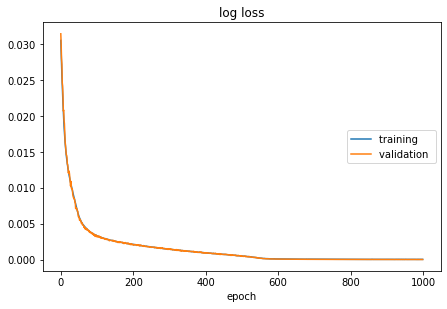

log loss
	training         	 (min:    0.000, max:    0.031, cur:    0.000)
	validation       	 (min:    0.000, max:    0.031, cur:    0.000)

[1000/1000]    {'log loss': 3.736289363587275e-05, 'val_log loss': 1.834511203924194e-05}

Trained.


In [26]:
%%time 
criterion = torch.nn.MSELoss()
# criterion = FocalLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005) # [0.001 .. 0.0005 ... 0.0001] 0.001 per 10 epochs & 0.00001 per 1000 epochs

train_model_l1(model, criterion, optimizer, num_epochs=1000) # start @ 10:35:30

In [27]:
%%time
validation_dataset = data_from_dir("../data/dataset/test", resample=False) # load already prepared and resampled files
print("Dataset size: ", len(validation_dataset))

# check one file in dataset to be sure everything is good:
file_number=25
wave = validation_dataset[file_number][0]
sr = 48000

print('Type:              ', type(wave))
print('Data:              ', wave)
print('Sampling rate:     ', sr)
print('Samples:           ', len(wave))
print('Audio length:      ', round(wave.size/sr, 4), 'seconds')
print('Lowest amplitude:  ', min(wave))
print('Highest amplitude: ', max(wave))
print()
print("Scaled from dataset:")
Audio(wave, rate=sr)

Dataset size:  524
Type:               <class 'numpy.ndarray'>
Data:               [ -366   -15   -30 ... -2446 -1957 -1131]
Sampling rate:      48000
Samples:            240000
Audio length:       5.0 seconds
Lowest amplitude:   -27736
Highest amplitude:  32767

Scaled from dataset:
CPU times: user 105 ms, sys: 3.04 ms, total: 108 ms
Wall time: 110 ms


In [28]:
wave = validation_dataset[file_number][0]
amplitude_range = 32767*2+1.0 # = 65535
inputs = torch.Tensor([[0.5 + wave/amplitude_range]]) # [0..1]
inputs = inputs.to(device)
outputs = model.l1(inputs)
loss = (criterion(outputs, inputs))
print(f"loss: {loss.item()}")
result = np.int16(((outputs - 0.5)*(amplitude_range-1)).detach().cpu())
Audio(result[0][0], rate=sr)

loss: 1.426737890142249e-05


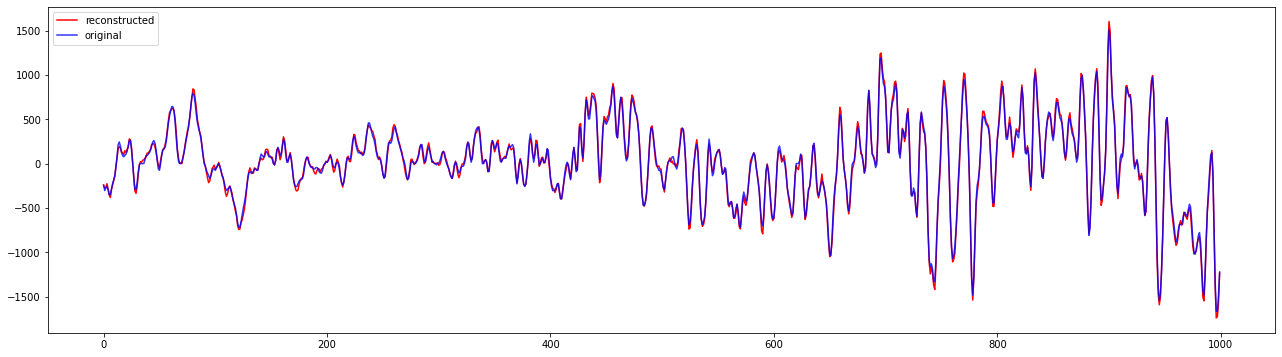

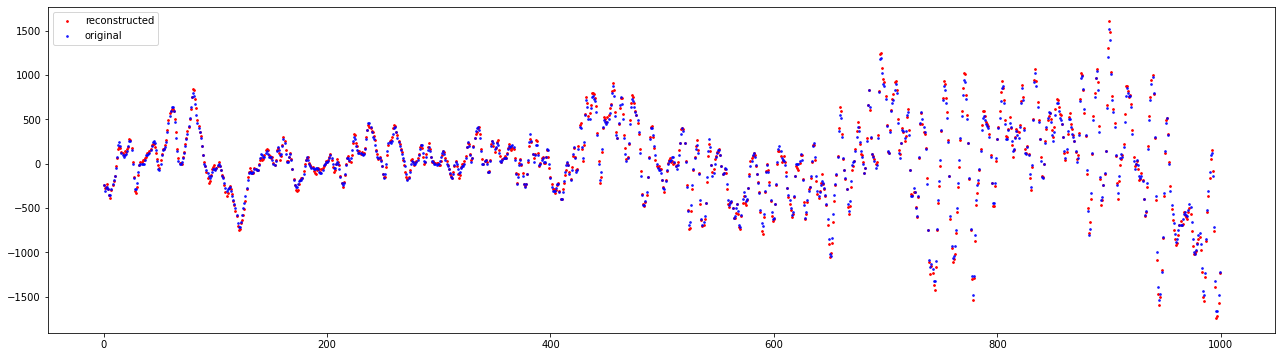

In [29]:
amp_start = 1000
amp_end =   2000
plt.figure(figsize=(22,6))
plt.plot(result[0][0][amp_start:amp_end], linestyle="-", color=[1.0, 0.0, 0.0, 1.0], label="reconstructed") # plotting by columns
plt.plot(wave[amp_start:amp_end], linestyle="-", color=[0.0, 0.0, 1.0, 0.8], label="original") # plotting by columns
plt.legend(loc="upper left")
plt.show()

plt.figure(figsize=(22,6))
x = np.arange(0, amp_end-amp_start)
plt.scatter(x, result[0][0][amp_start:amp_end], s=3, color=[1.0, 0.0, 0.0, 1.0], label="reconstructed") # plotting by columns
plt.scatter(x, wave[amp_start:amp_end], s=3, color=[0.0, 0.0, 1.0, 0.8], label="original") # plotting by columns
plt.legend(loc="upper left")
plt.show()

In [30]:
model_path = "../models/ConvAutoEncoder.l1.model.pt"
torch.save(model, model_path)
os.chown(model_path, 1000, 1000)

/opt/miniconda/lib/python3.6/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type ConvAutoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [32]:
# NOW WILL TRAIN LAYER BY LAYER
# LAYER 2

In [47]:
# train on cuda if available
torch.cuda.empty_cache()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# train with (test on each epoch)
def train_model_l2(model, criterion, optimizer, num_epochs=10):
    liveloss = PlotLosses()
    model = model.to(device)
    amplitude_range = 32767*2 + 1.0 # = 65535
#     softmaxed = torch.nn.Softmax()
    
    for epoch_id, epoch in enumerate(range(num_epochs)):
        logs = {}
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
                model.enc1bn.eval()
                model.dec1bn.eval()
            else:
                model.eval()

            running_loss = 0.0
            # running_corrects = 0 # no correct answers for autoencoders

            for idx, inputs in enumerate(dataloaders[phase]):
                inputs = 0.5 + (inputs/amplitude_range) # [0..1]
                inputs = inputs.to(device)
                outputs = model.l2(inputs)
                loss = (criterion(outputs, inputs))

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                # _, preds = torch.max(outputs, 1) # no correct answers for autoencoders
                running_loss += loss.detach() * inputs.size(0)
                # running_corrects += torch.sum(preds == inputs.data) # no correct answers for autoencoders
                # running_corrects += torch.sum(preds == labels.data) # no correct answers for autoencoders
                ###print(f"\r[{idx}/{len(source_files)}] {round(100.0 * idx/len(source_files), 2)}%: {j}", end = "")
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            # epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
            
            prefix = ''
            if phase == 'test':
                prefix = 'val_'
            logs[prefix + 'log loss'] = epoch_loss.item()
        liveloss.update(logs)
        liveloss.send()
        print(f"\n[{epoch_id+1}/{num_epochs}]    {logs}")
    print("\nTrained.")

In [50]:
%%time
torch.cuda.empty_cache()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
loaded_model = torch.load(model_path, map_location=device)
model = ConvAutoencoder()
model.cuda() # need to be set to cuda to get summary working

# copy loaded model to model
model.enc1co = copy.deepcopy(loaded_model.enc1co)
model.enc1bn = copy.deepcopy(loaded_model.enc1bn)
model.enc1co.weight.requires_grad=False
# model.enc1co.bias.requires_grad=False
model.enc1bn.weight.requires_grad=False
# model.enc1bn.bias.requires_grad=False

model.dec1uco = copy.deepcopy(loaded_model.dec1uco)
model.dec1bn = copy.deepcopy(loaded_model.dec1bn)
model.dec1uco.weight.requires_grad=False
# model.dec1uco.bias.requires_grad=False
model.dec1bn.weight.requires_grad=False
# model.dec1bn.bias.requires_grad=False

summary(model, (1, 240000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 32, 15000]           2,048
       BatchNorm1d-2            [-1, 32, 15000]              64
         LeakyReLU-3            [-1, 32, 15000]               0
            Conv1d-4             [-1, 64, 3000]          51,200
       BatchNorm1d-5             [-1, 64, 3000]             128
         LeakyReLU-6             [-1, 64, 3000]               0
         MaxPool1d-7  [[-1, 64, 600], [-1, 64, 600]]               0
            Conv1d-8             [-1, 128, 120]         204,800
       BatchNorm1d-9             [-1, 128, 120]             256
        LeakyReLU-10             [-1, 128, 120]               0
        MaxPool1d-11  [[-1, 128, 24], [-1, 128, 24]]               0
           Conv1d-12               [-1, 256, 6]         524,288
      BatchNorm1d-13               [-1, 256, 6]             512
        LeakyReLU-14         

In [ ]:
model.enc1bn == loaded_model.enc1bn

In [ ]:
model.enc2bn == loaded_model.enc2bn

In [51]:
# now freeze previously trained layers:

# model.enc2co.weight.requires_grad=False
# model.enc2co.bias.requires_grad=False
# model.enc2bn.weight.requires_grad=False
# model.enc2bn.bias.requires_grad=False

# model.dec2uco.weight.requires_grad=False
# model.dec2uco.bias.requires_grad=False
# model.dec2bn.weight.requires_grad=False
# model.dec2bn.bias.requires_grad=False


# dont forget to set .eval() on every freezed BN in class description!!!

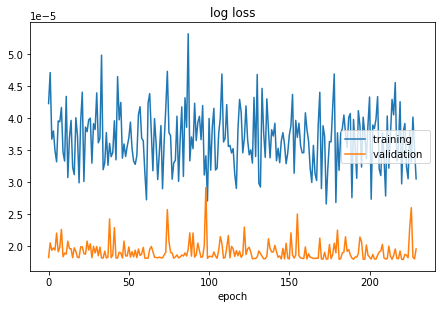

log loss
	training         	 (min:    0.000, max:    0.000, cur:    0.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)

[230/1000]    {'log loss': 3.0489860364468768e-05, 'val_log loss': 1.9506098396959715e-05}


KeyboardInterrupt: 

In [52]:
criterion = torch.nn.MSELoss()
# criterion = FocalLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.00005) # [0.001 .. 0.0005 ... 0.0001] 0.001 per 10 epochs & 0.00001 per 1000 epochs

train_model_l1(model, criterion, optimizer, num_epochs=1000) # start @ 10:35:30

In [53]:
model.l1

<bound method ConvAutoencoder.l1 of ConvAutoencoder(
  (activation): LeakyReLU(negative_slope=0.1)
  (enc1co): Conv1d(1, 32, kernel_size=(64,), stride=(16,), padding=(31,), bias=False)
  (enc1bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc1ac): LeakyReLU(negative_slope=0.1)
  (enc2co): Conv1d(32, 64, kernel_size=(25,), stride=(5,), padding=(12,), bias=False)
  (enc2bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc2ac): LeakyReLU(negative_slope=0.1)
  (enc2mp): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (enc3co): Conv1d(64, 128, kernel_size=(25,), stride=(5,), padding=(12,), bias=False)
  (enc3bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc3ac): LeakyReLU(negative_slope=0.1)
  (enc3mp): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (enc4co): Conv1d(128, 256, kernel_size=(16,), stride=(4,), padd

In [ ]:
%%time
validation_dataset = data_from_dir("../data/dataset/test", resample=False) # load already prepared and resampled files
print("Dataset size: ", len(validation_dataset))

# check one file in dataset to be sure everything is good:
file_number=25
wave = validation_dataset[file_number][0]
sr = 48000

print('Type:              ', type(wave))
print('Data:              ', wave)
print('Sampling rate:     ', sr)
print('Samples:           ', len(wave))
print('Audio length:      ', round(wave.size/sr, 4), 'seconds')
print('Lowest amplitude:  ', min(wave))
print('Highest amplitude: ', max(wave))
print()
print("Scaled from dataset:")
Audio(wave, rate=sr)

In [ ]:
wave = validation_dataset[file_number][0]
amplitude_range = 32767*2+1.0 # = 65535
inputs = torch.Tensor([[0.5 + wave/amplitude_range]]) # [0..1]
inputs = inputs.to(device)
outputs = model.l2(inputs)
loss = (criterion(outputs, inputs))
print(f"loss: {loss.item()}")
result = np.int16(((outputs - 0.5)*(amplitude_range-1)).detach().cpu())
Audio(result[0][0], rate=sr)

In [ ]:
amp_start = 1000
amp_end =   2000
plt.figure(figsize=(22,6))
plt.plot(result[0][0][amp_start:amp_end], linestyle="-", color=[1.0, 0.0, 0.0, 1.0], label="reconstructed") # plotting by columns
plt.plot(wave[amp_start:amp_end], linestyle="-", color=[0.0, 0.0, 1.0, 0.8], label="original") # plotting by columns
plt.legend(loc="upper left")
plt.show()

plt.figure(figsize=(22,6))
x = np.arange(0, amp_end-amp_start)
plt.scatter(x, result[0][0][amp_start:amp_end], s=3, color=[1.0, 0.0, 0.0, 1.0], label="reconstructed") # plotting by columns
plt.scatter(x, wave[amp_start:amp_end], s=3, color=[0.0, 0.0, 1.0, 0.8], label="original") # plotting by columns
plt.legend(loc="upper left")
plt.show()

In [ ]:
model_path = "../models/ConvAutoEncoder.l2.model.pt"
torch.save(model, model_path)
os.chown(model_path, 1000, 1000)

In [ ]:
# NOW WILL TRAIN LAYER BY LAYER
# LAYER 3